In [1]:
import pandas as pd
from pandas.io.json import json_normalize
import json
import re
import networkx as nx
import numpy as np
import math
from scipy.spatial import distance
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from transform_data import json_to_df, clean_listing_df, get_room_listings

print('pd.__version:', pd.__version__)
print('nx.__version:', nx.__version__)

pd.options.display.max_columns = 100
sns.set(rc={'figure.figsize':(20,10)})

FP = 'C://Users//Neil_//PycharmProjects//tuberent//'

MAPBOX_TOKEN = 'pk.eyJ1IjoibmhvbGxvIiwiYSI6ImNrNmllZnpkZzAwOWkzc3M1dHMydTFvaHAifQ.2Dathgh6fopbNbf_SAwmMg'

pd.__version: 0.25.1
nx.__version: 2.3


### utility finctions

In [13]:
def find_closest_station(coord, df_sta):
    '''Naively searches for closest station in df_sta to given lat, lon pair input. Distacne calculated using the Haversine formula'''
    
    if np.isnan(coord[0]) or np.isnan(coord[1]):
        return ''
    
    station_coords = [(r.latitude, r.longitude) for i,r in df_sta.iterrows()]
    
    d = []
    for sc in station_coords:
        
        lat1 = math.radians(coord[0])
        lat2 = math.radians(sc[0])
        dlat = lat1 - lat2
        dlon = math.radians(coord[1] - sc[1])
        
        a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
        
        #R = Radius of Earth
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a)) # * R

        d.append(c)
    df_sta['d'] = d
    
    df_sta = df_sta.loc[df_sta.d == min(df_sta.d)]
    return df_sta.name.values[0]

def stacked_price_density(df, grp_field, grp_name = None):
    
    if grp_name == None:
        grp_name = grp_field
    
    plot_df = df.merge(df_rooms, on = 'id', how = 'inner')
    zones = plot_df[grp_field].unique().tolist()

    sns.set_palette("husl")
    plt.figure(figsize=(25,10))
    for zone in zones:
        
        try:
            sns.distplot(plot_df.loc[plot_df[grp_field] == zone, 'room_price_pw'], 
                         hist = False, 
                         kde = True, kde_kws = {'shade': True, 'linewidth': 2.5, 'alpha' : .25},
                         label = zone)
        except:
            print(f'error with {grp_name} {zone}, skipping from plot')
        
    _=plt.legend(prop={'size': 16}, title = grp_name)
    _=plt.title(f'Spare room rent prices by {grp_name}', size = 20)
    _=plt.xlabel('Rent (£, pw)')
    _=plt.ylabel('Density')

### load and transform data

In [3]:
# London tube network data courtsey of https://github.com/nicola/tubemaps
df_con = pd.read_csv(FP + 'london.connections.csv')
df_lin = pd.read_csv(FP + 'london.lines.csv')
df_sta = pd.read_csv(FP + 'london.stations.csv')

# Scrape data, see id_grabber.py
df = json_to_df(FP + 'listing_data_feb.json')
df = clean_listing_df(df)
df_rooms = get_room_listings(df)
df['closest_station'] = df.apply(lambda x: find_closest_station((x['latitude'], x['longitude']), df_sta), axis = 1)

ZONE1: 1006
ZONE2: 1076
ZONE3: 1028
ZONE4: 999
ZONE5: 1000
ZONE6: 897


### prepare dataframe for plotly mapbox plot

In [4]:
df_data = df[['id', 'closest_station', 'latitude', 'longitude']].merge(df_rooms, on = 'id')
df_sta = df_sta.merge(df_data.groupby('closest_station')['room_price_pcm'].agg({'room_price_pcm' : lambda x: int(x.mean()),
                                                                                'room_count' : 'count'}).reset_index(), 
                      left_on = 'name',
                      right_on = 'closest_station',
                     how = 'left')

df_sta['label'] = df_sta.name.map(str) + ' (£' + df_sta.room_price_pcm.map(str) +')'

C:\Users\Neil_\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)




### define graph of tube network

In [5]:
g = nx.from_pandas_edgelist(df_con.merge(df_lin, on = 'line'),
                            'station1',
                            'station2',
                            edge_attr= ['line', 'name', 'colour'])

station_attrs = df_sta.set_index('id').to_dict('id')
nx.set_node_attributes(g, station_attrs)

### mapbox plotly plots

In [6]:
fig = go.Figure()

edge_traces = []
for i,r in df_lin.iterrows():
    
    line_name = r['name']
    line_colour = line = r['colour']
    edge_x = []
    edge_y = []
    for edge in g.edges(data=True):
        
        if edge[2]['name'] == line_name:
            x0, y0 = g.nodes[edge[0]]['longitude'], g.nodes[edge[0]]['latitude']
            x1, y1 = g.nodes[edge[1]]['longitude'], g.nodes[edge[1]]['latitude']
            edge_x.append(x0)
            edge_x.append(x1)
            edge_x.append(None)
            edge_y.append(y0)
            edge_y.append(y1)
            edge_y.append(None)


    edge_trace = go.Scattermapbox(
        lon=edge_x, lat=edge_y,
        line=dict(width=2, color='#'+line_colour),
        opacity = .7,
        name=line_name,
        mode='lines',
        showlegend=True, hoverinfo = 'text', text = line_name)
    
    edge_traces.append(edge_trace)
    fig.add_trace(edge_trace)
    
node_x = []
node_y = []
labels = []
marker_sizes = []
for node in g.nodes():
    x, y = g.nodes[node]['longitude'], g.nodes[node]['latitude']
    node_x.append(x)
    node_y.append(y)
    
    pr = 'NA' if np.isnan(g.nodes[node]['room_price_pcm']) else str(int(g.nodes[node]['room_price_pcm']))
    rms = 'NA' if np.isnan(g.nodes[node]['room_count']) else str(int(g.nodes[node]['room_count']))
    labels.append(
        'Station: ' + g.nodes[node]['name'] + '<Br>' +  
        'Avg. Spareroom price (£, pcm): ' + pr + '<Br>' +
        'Rooms listed: ' + rms + '<Br>' +        
        'Tube Zone: ' + str(int(g.nodes[node]['zone']))
    )
    marker_sizes.append(g.nodes[node]['room_price_pcm'])
    
marker_sizes = [np.nanmean(marker_sizes) if np.isnan(x) else x for x in marker_sizes]
marker_sizes = 15 * np.array(marker_sizes) / np.mean(marker_sizes)

node_trace = go.Scattermapbox(lon=node_x, lat=node_y,
                              mode='markers',
                              marker = dict(size = marker_sizes,
                                            color = marker_sizes,
                                            opacity = .7,
                                            colorscale = "Sunset"),
                              hoverinfo = 'text', 
                              text = labels,
                              showlegend = False)
fig.add_trace(node_trace)

fig.update_layout(mapbox_style= "carto-darkmatter",
                  autosize = True,
                  mapbox_zoom = 10.5,
                  mapbox_center_lat = 51.55,
                  mapbox_center_lon = -.1, 
                  mapbox_accesstoken = MAPBOX_TOKEN)

fig.write_html('tube_network.html', auto_open=True)

In [7]:
px.set_mapbox_access_token(MAPBOX_TOKEN)
fig2 = px.scatter_mapbox(df_data,
                  lat ="latitude", lon = "longitude",
                  color = "room_price_pcm", size = "room_price_pcm", opacity = .7,
                  color_continuous_scale = px.colors.cyclical.IceFire, range_color = [200, 1500], mapbox_style = 'carto-darkmatter',
                  size_max = 15,
                  zoom = 10.5)
for edge_trace in edge_traces:
    fig2.add_trace(edge_trace)

fig2.write_html('listings_scatter.html', auto_open=True)

### Density plots

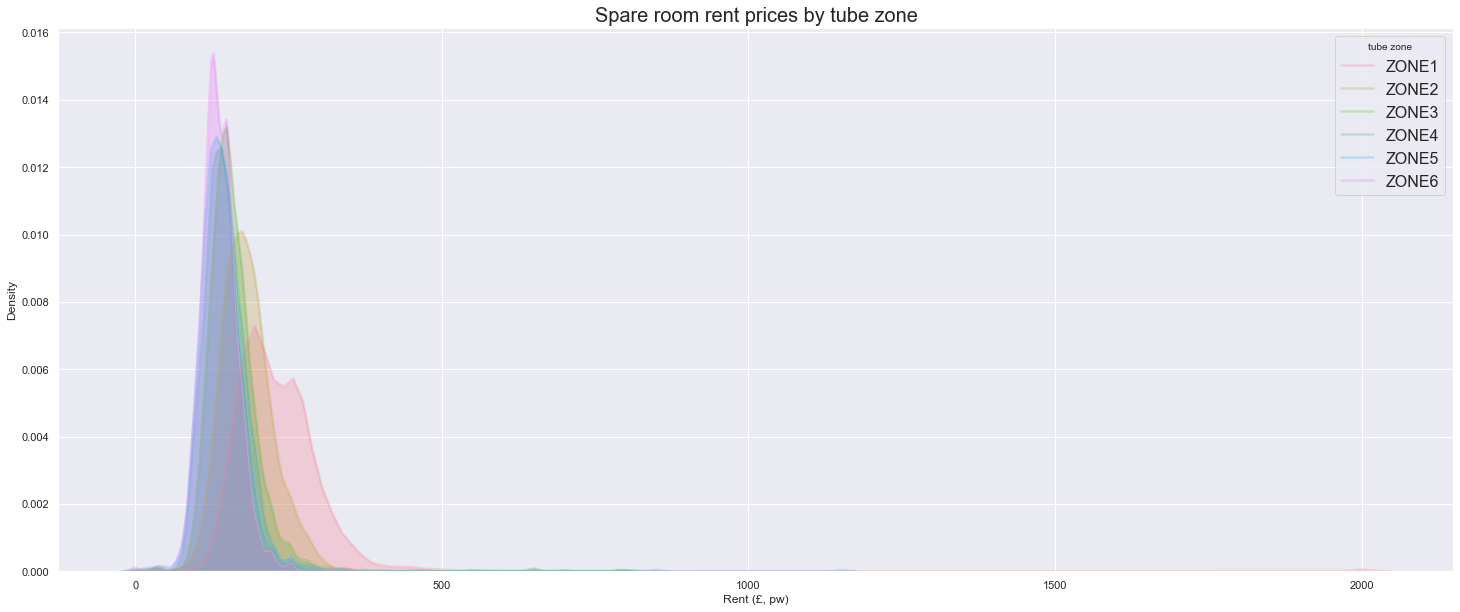

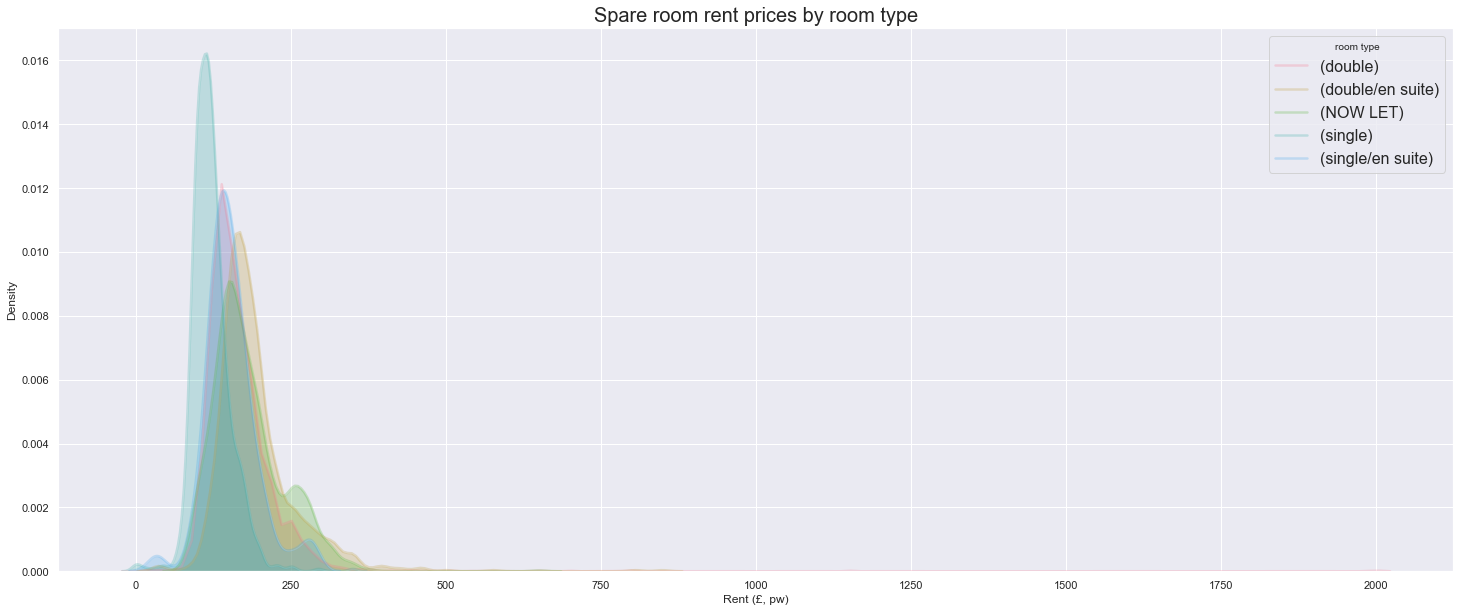

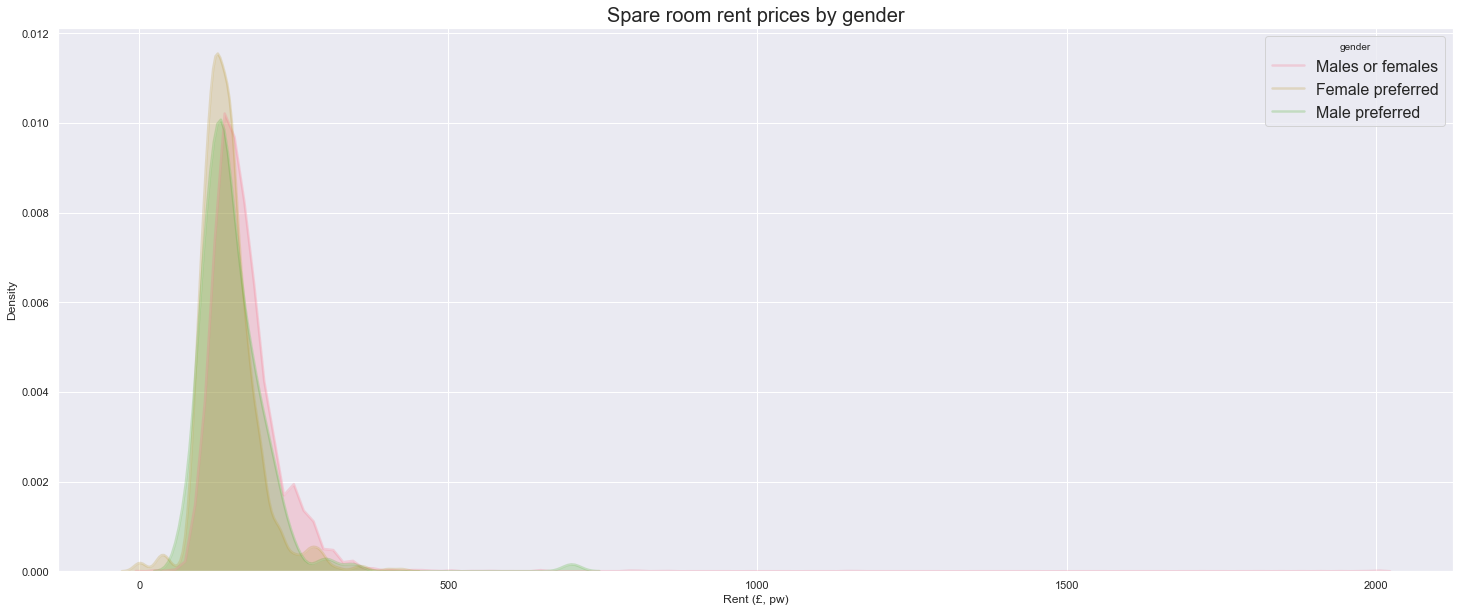

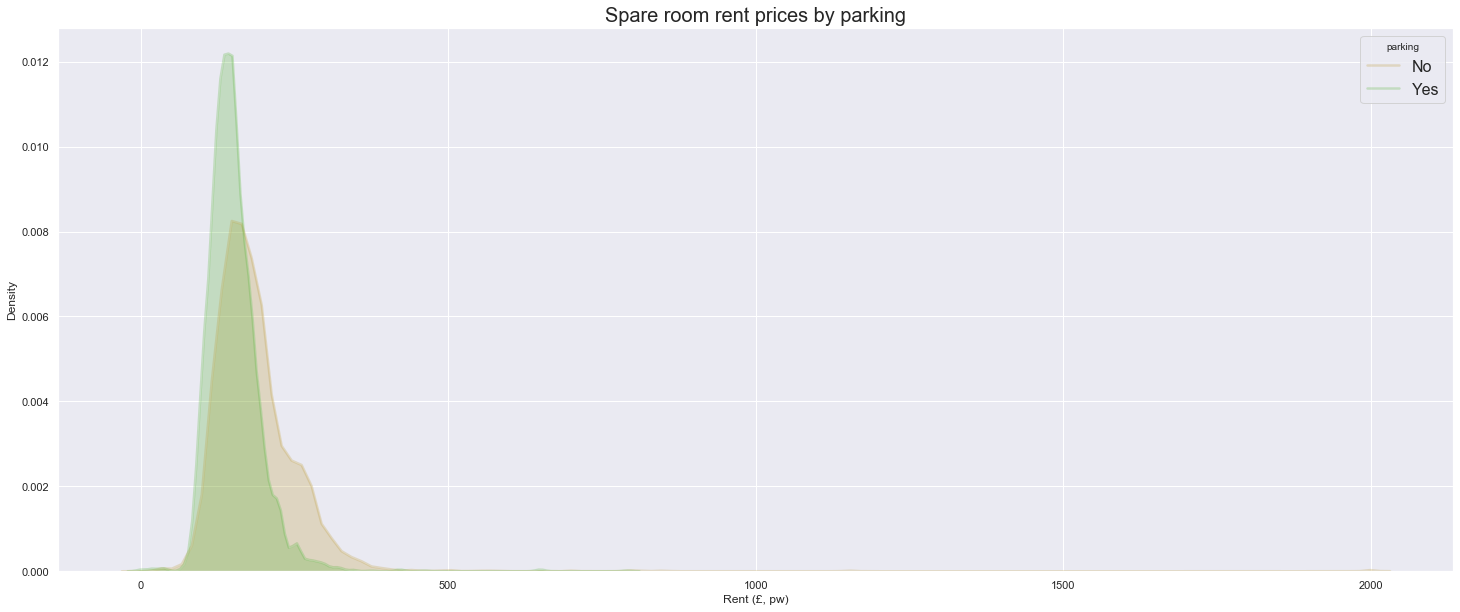

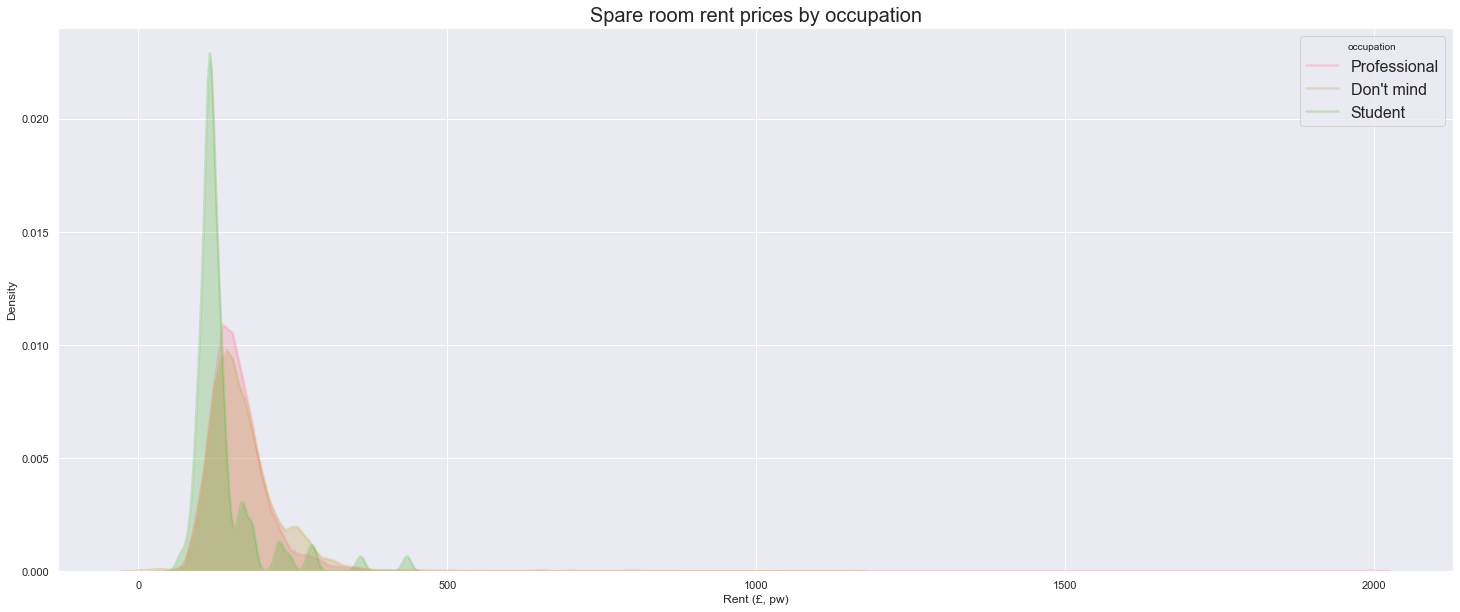

In [14]:
stacked_price_density(df, 'tube_zone', 'tube zone')
plt.show()
stacked_price_density(df, 'room_type', 'room type')
plt.show()
stacked_price_density(df, 'gender')
plt.show()
stacked_price_density(df, 'parking')
plt.show()
stacked_price_density(df, 'occupation')